In [49]:
import simpy
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ETAPA 1: EXTRAÇÃO DE DADOS

def get_process_times_from_csv(arquivo):
    """Lê um arquivo CSV Yamazumi, aplica um fator de calibração e extrai os tempos."""
    def converter_tempo_para_segundos(tempo_str):
        if pd.isna(tempo_str) or not isinstance(tempo_str, str): return 0
        parts = str(tempo_str).split(':')
        try:
            if len(parts) == 3: h, m, s = map(int, parts); return h * 3600 + m * 60 + s
            if len(parts) == 2: m, s = map(int, parts); return m * 60 + s
        except (ValueError, TypeError): return 0
        return 0

    try:
        if not os.path.exists(arquivo): return None
        df = pd.read_csv(arquivo, header=5, sep=';', encoding='latin1', on_bad_lines='skip')
        class_col = next((col for col in df.columns if 'Classifica' in col), None)
        if not class_col: return None
        total_row = df[df[class_col] == 'Total'].copy()
        if total_row.empty: return None

        start_col = df.columns.get_loc(class_col) + 1
        end_col = len(df.columns)
        try: end_col = df.columns.get_loc('Coluna1')
        except KeyError: pass
            
        colunas_postos = df.columns[start_col:end_col]
        tempos_totais = total_row[colunas_postos].dropna(axis=1, how='all')
        tempos_formatados = tempos_totais.melt(var_name='Posto', value_name='Tempo_str')
        
        # Aplica o fator de calibração aqui
        tempos_formatados['Tempo_segundos'] = tempos_formatados['Tempo_str'].apply(converter_tempo_para_segundos)
        
        return pd.Series(tempos_formatados.Tempo_segundos.values, index=tempos_formatados.Posto).to_dict()

    except Exception: return None

# --- PARÂMETROS GLOBAIS ---
# FATOR_DE_CALIBRACAO = 0.15 
NUM_OPERADORES_PERNA1 = 14  
NUM_OPERADORES_PERNA2 = 11  
HORAS_SIMULACAO = 8
META_PRODUCAO = 76
HORAS_META = 7.7 
TAKT_TIME_SEGUNDOS = 5.5 * 60



MODELOS_CSV ={
    "Accelo": {"baumuster": ["C951102", "C951104", "C951111"], "perna": 1, "tempos": "Yamazumi - Accelo.csv"},
    "Atego": {"baumuster":["C951500", "C951501", "C951511", "C951514", "C951530", "C951544"],"perna": 1, "tempos":"Yamazumi - Atego.csv"},
    "Atego (ATP)":{"baumuster": ["C968403", "C968114"], "perna": 1, "tempos":"Yamazumi - ATP.csv"}, 
    "Actros":{"baumuster": ["C963400", "C963403", "C963411", "C963414", "C963424", "C963425"], "perna": 2, "tempos":"Yamazumi - Actros.csv"},
    "Arocs": {"baumuster":["C964016", "C964216", "C964231", "C964416"], "perna": 2, "tempos":"Yamazumi - Arocs.csv"},
    "Axor (ATP +)":{"baumuster": ["C968150", "C968450", "C968453", "C968461", "C968475"], "perna":2, "tempos": "Yamazumi - Actros.csv"}
}

print("--- Carregando e Calibrando Dados de Processo ---")
#PROCESSOS_FABRICA = {modelo: get_process_times_from_csv(arquivo) for modelo, arquivo in MODELOS_CSV[modelo]["tempos"]}
PROCESSOS_FABRICA = {
    modelo: get_process_times_from_csv(dados["tempos"])
    for modelo, dados in MODELOS_CSV.items()
}
PROCESSOS_FABRICA = {k: v for k, v in PROCESSOS_FABRICA.items() if v}
print(PROCESSOS_FABRICA)
print(f"Dados para {len(PROCESSOS_FABRICA.keys())} modelos carregados com sucesso.")

print(PROCESSOS_FABRICA)


--- Carregando e Calibrando Dados de Processo ---
{'Accelo': {'Arrefec.': 316, 'Diesel': 253, 'Reaperto': 235, 'Estepe': 290, 'Pneu LD': 250, 'Pneu LE': 250, 'Aperto LD': 304, 'Aperto LE': 304, 'Grade': 270, 'MecÃ¢nica 1': 194, 'MecÃ¢nica 2': 194, 'ElÃ©trica 1 ': 357, 'ElÃ©trica 2': 357, 'Controle ': 265, 'Motorista': 266, 'Quis': 270}, 'Atego': {'Arrefec.': 314, 'Diesel': 314, 'Reaperto': 294, 'Estepe': 267, 'Pneu LD': 308, 'Pneu LE': 308, 'Aperto LD': 315, 'Aperto LE': 315, 'Grade': 234, 'MecÃ¢nica 1': 194, 'MecÃ¢nica 2': 194, 'ElÃ©trica 1 ': 360, 'ElÃ©trica 2': 360, 'Controle ': 275, 'Motorista': 266, 'Quis': 270}, 'Atego (ATP)': {'Arrefec.': 330, 'Diesel': 326, 'Reaperto': 557, '5Âª Roda': 724, 'Estepe': 319, 'Pneu LD': 256, 'Pneu LE': 256, 'Aperto LD': 323, 'Aperto LE': 323, 'Grade': 230, 'MecÃ¢nica 1': 194, 'MecÃ¢nica 2': 194, 'ElÃ©trica 1 ': 360, 'ElÃ©trica 2': 360, 'Controle ': 275, 'Motorista': 266, 'Quis': 270}, 'Actros': {'Abastecimento': 555, 'Passa-disÃ§o': 752, 'Chineleir

## TESTE da MELINA

ETAPA 1 - OBTENDO INFORMAÇÕES YAMAZUMI

In [50]:
import pandas as pd
import simpy
import os
import re
from unidecode import unidecode


# OBTENDO TEMPOS POR ATIVIDADES DOS ARQUIVOS YAMAZUMI 
def get_process_times_from_csv(arquivo):
    """Lê um CSV Yamazumi, extrai os tempos por atividade e retorna um dicionário {atividade: tempo_em_segundos}."""
    
    def converter_tempo_para_segundos(tempo_str):
        if pd.isna(tempo_str) or not isinstance(tempo_str, str):
            return 0
        parts = str(tempo_str).split(':')
        try:
            if len(parts) == 3:
                h, m, s = map(int, parts)
                return h * 3600 + m * 60 + s
            elif len(parts) == 2:
                m, s = map(int, parts)
                return m * 60 + s
        except Exception:
            return 0
        return 0

    if not os.path.exists(arquivo):
        return {}

    df = pd.read_csv(arquivo, header=5, sep=';', encoding='latin1', on_bad_lines='skip')

    def normalizar_coluna(col):
        col = unidecode(col)
        col = col.upper()
        col = re.sub(r"[\"\'().\-\/]", "", col)
        col = re.sub(r"\s+", "_", col)
        return col.strip("_")

    df.columns = [normalizar_coluna(col) for col in df.columns]

    class_col = next((col for col in df.columns if 'CLASSIFICA' in col), None)
    if not class_col:
        return {}

    total_row = df[df[class_col] == 'Total'].copy()
    if total_row.empty:
        return {}

    start_col = df.columns.get_loc(class_col) + 1
    end_col = len(df.columns)
    try:
        end_col = df.columns.get_loc('COLUNA1')
    except KeyError:
        pass

    colunas_postos = df.columns[start_col:end_col]
    tempos_totais = total_row[colunas_postos].dropna(axis=1, how='all')
    tempos_formatados = tempos_totais.melt(var_name='Atividade', value_name='Tempo_str')
    tempos_formatados['Tempo_segundos'] = tempos_formatados['Tempo_str'].apply(converter_tempo_para_segundos)

    return pd.Series(tempos_formatados.Tempo_segundos.values, index=tempos_formatados.Atividade).to_dict()


# --- Dicionários ---
MODELOS_CSV = {
    "Accelo": {"baumuster": ["C951102", "C951104", "C951111"], "perna": 1, "tempos": "Yamazumi - Accelo.csv"},
    "Atego": {"baumuster":["C951500", "C951501", "C951511", "C951514", "C951530", "C951544"],"perna": 1, "tempos":"Yamazumi - Atego.csv"},
    "Atego (ATP)":{"baumuster": ["C968403", "C968114"], "perna": 1, "tempos":"Yamazumi - ATP.csv"}, 
    "Actros":{"baumuster": ["C963400", "C963403", "C963411", "C963414", "C963424", "C963425"], "perna": 2, "tempos":"Yamazumi - Actros.csv"},
    "Arocs": {"baumuster":["C964016", "C964216", "C964231", "C964416"], "perna": 2, "tempos":"Yamazumi - Arocs.csv"},
    "Axor (ATP +)":{"baumuster": ["C968150", "C968450", "C968453", "C968461", "C968475"], "perna":2, "tempos": "Yamazumi - Actros.csv"}
}

POSTOS_ATIVIDADES = {
    "Accelo": {'30A':{'atividades': ['ARREFEC'],'operadores': 1},'31A':{'atividades':['DIESEL','REAPERTO'], 'operadores':2},
               '32A':{'atividades':['ESTEPE','5AA_RODA'], 'operadores':2}, '32C':{'atividades':['PNEU_LD','PNEU_LE'], 'operadores':1},
                '33A':{'atividades':['APERTO_LD','APERTO_LE'],'operadores':2},'34A':{'atividades':['GRADE','MECACNICA_1','MECACNICA_2','ELECTRICA_1','ELECTRICA_2'],'operadores':2},
                '38':{'atividades':['CONTROLE','MOTORISTA','QUIS'],'operadores':1}},
    "Atego": {'30A':{'atividades': ['ARREFEC'],'operadores': 1},'31A':{'atividades':['DIESEL','REAPERTO'], 'operadores':2},
               '32A':{'atividades':['ESTEPE','5AA_RODA'], 'operadores':2}, '32C':{'atividades':['PNEU_LD','PNEU_LE'], 'operadores':1},
                '33A':{'atividades':['APERTO_LD','APERTO_LE'],'operadores':2},'34A':{'atividades':['GRADE','MECACNICA_1','MECACNICA_2','ELECTRICA_1','ELECTRICA_2'],'operadores':2},
                '38':{'atividades':['CONTROLE','MOTORISTA','QUIS'],'operadores':1}},
    "Atego (ATP)":{'30A':{'atividades': ['ARREFEC'],'operadores': 1},'31A':{'atividades':['DIESEL','REAPERTO'], 'operadores':2},
               '32A':{'atividades':['ESTEPE'], 'operadores':2}, '32C':{'atividades':['5AA_RODA','PNEU_LD','PNEU_LE'], 'operadores':1},
                '33A':{'atividades':['APERTO_LD','APERTO_LE'],'operadores':2},'34A':{'atividades':['GRADE','MECACNICA_1','MECACNICA_2','ELECTRICA_1','ELECTRICA_2'],'operadores':2},
                '38':{'atividades':['CONTROLE','MOTORISTA','QUIS'],'operadores':1}}, 
    "Actros":{"30B": {'atividades':["ABASTECIMENTO"],'operadores':2}, "31B": {'atividades':[ "PASSADISASSO"],'operadores':2},
              '32B':{'atividades':['CHINELEIRA'],'operadores':2},'32D':{'atividades':['5AA_RODA'],'operadores':2},
              '33B':{'atividades':['PNEU_LD','PNEU_LE'],'operadores':2}, '34B':{'atividades':['PARALAMA_LD','PARALAMA_LE'],'operadores':2}, 
              '39':{'atividades':['CONTROLE','ELACTRICA_I''ELACTRICA_II','ELACTRICA_3','COLUNA5'],'operadores':2}},
    "Arocs": {"30B": {'atividades':["ABASTECIMENTO"],'operadores':2}, "31B": {'atividades':[ "PASSADISASSO"],'operadores':2},
              '32B':{'atividades':['CHINELEIRA'],'operadores':2},'32D':{'atividades':['5AA_RODA'],'operadores':2},
              '33B':{'atividades':['PNEU_LD','PNEU_LE'],'operadores':2}, '34B':{'atividades':['PARALAMA_LD','PARALAMA_LE'],'operadores':2}, 
              '39':{'atividades':['CONTROLE','ELACTRICA_I''ELACTRICA_II','ELACTRICA_3','COLUNA5'],'operadores':2}},
    "Axor (ATP +)":{"30B": {'atividades':["ABASTECIMENTO"],'operadores':2}, "31B": {'atividades':[ "PASSADISASSO"],'operadores':2},
              '32B':{'atividades':['CHINELEIRA'],'operadores':2},'32D':{'atividades':['5AA_RODA'],'operadores':2},
              '33B':{'atividades':['PNEU_LD','PNEU_LE'],'operadores':2}, '34B':{'atividades':['PARALAMA_LD','PARALAMA_LE'],'operadores':2}, 
              '39':{'atividades':['CONTROLE','ELACTRICA_I''ELACTRICA_II','ELACTRICA_3','COLUNA5'],'operadores':2}}
}


# DICIONÁRIO COM SOMA DOS TEMPOS POR POSTOS E TEMPOS POR OPERADOR
resultado = {}
for modelo, info in MODELOS_CSV.items():
    arquivo_csv = info["tempos"]
    tempos_atividades = get_process_times_from_csv(arquivo_csv)
    print(tempos_atividades)
    
    postos_dict = {}
    for posto, valor in POSTOS_ATIVIDADES[modelo].items():
        soma_tempo = sum(tempos_atividades.get(a.upper(), 0) for a in valor['atividades'])
        #print(soma_tempo)
        num_op = valor['operadores']
        tempo_op = soma_tempo / num_op if num_op != 0 else 0
        postos_dict[posto] = {
            'tempo_total': soma_tempo,
            'operador': num_op,
            'tempo_operador': tempo_op
        }
    
    resultado[modelo] = postos_dict

#print(resultado)
#print(postos_dict)
# print(list(resultado[modelo].keys()))

# --- Exibe resultado final ---
print("\n--- Tempos por posto por modelo ---")
for modelo, valor in resultado.items():
    print(f"{modelo}: {valor}")

{'ARREFEC': 316, 'DIESEL': 253, 'REAPERTO': 235, 'ESTEPE': 290, 'PNEU_LD': 250, 'PNEU_LE': 250, 'APERTO_LD': 304, 'APERTO_LE': 304, 'GRADE': 270, 'MECACNICA_1': 194, 'MECACNICA_2': 194, 'ELACTRICA_1': 357, 'ELACTRICA_2': 357, 'CONTROLE': 265, 'MOTORISTA': 266, 'QUIS': 270}
{'ARREFEC': 314, 'DIESEL': 314, 'REAPERTO': 294, 'ESTEPE': 267, 'PNEU_LD': 308, 'PNEU_LE': 308, 'APERTO_LD': 315, 'APERTO_LE': 315, 'GRADE': 234, 'MECACNICA_1': 194, 'MECACNICA_2': 194, 'ELACTRICA_1': 360, 'ELACTRICA_2': 360, 'CONTROLE': 275, 'MOTORISTA': 266, 'QUIS': 270}
{'ARREFEC': 330, 'DIESEL': 326, 'REAPERTO': 557, '5AA_RODA': 724, 'ESTEPE': 319, 'PNEU_LD': 256, 'PNEU_LE': 256, 'APERTO_LD': 323, 'APERTO_LE': 323, 'GRADE': 230, 'MECACNICA_1': 194, 'MECACNICA_2': 194, 'ELACTRICA_1': 360, 'ELACTRICA_2': 360, 'CONTROLE': 275, 'MOTORISTA': 266, 'QUIS': 270}
{'ABASTECIMENTO': 555, 'PASSADISASSO': 752, 'CHINELEIRA': 965, '5AA_RODA': 988, 'PNEU_LD': 407, 'PNEU_LE': 407, 'PARALAMA_LD': 800, 'PARALAMA_LE': 800, 'CONTROLE

ETAPA 2: OBTENDO DADOS SEQUENCIA DO DIA

In [51]:
sequencia = pd.read_csv("sequencia_producao.csv", sep=';')

# Extrai os 7 primeiros caracteres da coluna 'Baumuster'
sequencia['Baumuster_7dig'] = sequencia['Baumuster'].astype(str).str[:7]
sequencia_modelos = sequencia["Baumuster_7dig"].tolist()
print(sequencia_modelos)

['C951501', 'C951501', 'C968403', 'C968450', 'C951102', 'C963425', 'C951501', 'C968114', 'C951501', 'C951104', 'C951501', 'C963425', 'C951501', 'C968114', 'C951104', 'C963414', 'C963425', 'C963411', 'C963414', 'C951104', 'C968403', 'C951102', 'C963425', 'C951501', 'C951102', 'C951501', 'C968403', 'C963425', 'C951104', 'C951544', 'C951501', 'C963414', 'C951501', 'C951501', 'C951501', 'C963411', 'C951511', 'C951104', 'C951501', 'C963425', 'C951501', 'C951511', 'C951104', 'C963425', 'C951501', 'C968403', 'C951501', 'C963425', 'C951104', 'C968403', 'C951501', 'C963425', 'C951104', 'C951104', 'C963425', 'C951501', 'C951514', 'C963414', 'C951104', 'C951544', 'C951501', 'C951544', 'C951511', 'C963425', 'C951514', 'C951511', 'C963411', 'C951501', 'C968403', 'C951104', 'C963425', 'C951102', 'C951500', 'C951511', 'C963414', 'C951104', 'C951511', 'C951104', 'C963425', 'C951511', 'C951501', 'C964016', 'C951511', 'C951102', 'C968450', 'C951501', 'C963425', 'C951501', 'C968114', 'C951104', 'C951104'

ETAPA 3: OBTENDO QUANTOS MODELOS SÃO PRODUZIDOS POR PERNA POR TURNO

considerando a espera para entrar em um posto

In [52]:

# log_entrada_saida = []

# def processar_modelo(env, nome, modelo_nome, perna, postos_dict, recursos):
#     for posto, dados in postos_dict.items():
#         tempo_tot = dados["tempo_total"]
#         with recursos[posto].request() as req:
#             entrada = env.now
#             yield req
#             yield env.timeout(tempo_tot)
#             saida = env.now
#             log_entrada_saida.append({
#                 "modelo": modelo_nome,
#                 "nome": nome,
#                 "posto": posto,
#                 "entrada": entrada,
#                 "saida": saida,
#                 "duracao": saida - entrada,
#                 "perna": perna
#             })

# def simulacao_linha(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION):
#     env = simpy.Environment()
#     recursos = {}

#     def alimentador(env):
#         for i, baumuster in enumerate(sequencia_modelos):
#             yield env.timeout(TAKT_TIME * i)
#             modelo_nome, perna = None, None
#             for nome, dados in MODELOS_CSV.items():
#                 if baumuster in dados["baumuster"]:
#                     modelo_nome = nome
#                     perna = dados["perna"]
#                     break
#             if modelo_nome is None:
#                 continue
#             postos_dict = resultado[modelo_nome]
#             for posto in postos_dict:
#                 if posto not in recursos:
#                     recursos[posto] = simpy.Resource(env, capacity=1)
#             env.process(processar_modelo(
#                 env=env,
#                 nome=f"{modelo_nome}_{i}",
#                 modelo_nome=modelo_nome,
#                 perna=perna,
#                 postos_dict=postos_dict,
#                 recursos=recursos
#             ))

#     env.process(alimentador(env))
#     env.run(until=TURN_DURATION)

#     return pd.DataFrame(log_entrada_saida)

# # Simulação (executar localmente)
# df_log = simulacao_linha(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION)

# pd.set_option('display.max_rows', None)
# print(df_log)

sem considerar a espera para entrar em outro posto, contínuo

In [53]:
import pandas as pd
import simpy

log_entrada_saida = []

def processar_modelo_sem_restricao(env, nome, modelo_nome, perna, postos_dict):
    tempo_acumulado = 0
    for posto, dados in postos_dict.items():
        tempo_entrada = env.now + tempo_acumulado
        tempo_processamento = dados["tempo_total"]
        tempo_saida = tempo_entrada + tempo_processamento

        # Log de entrada e saída
        log_entrada_saida.append({
            "modelo": modelo_nome,
            "nome": nome,
            "posto": posto,
            "entrada": tempo_entrada,
            "saida": tempo_saida,
            "duracao": tempo_processamento,
            "perna": perna
        })

        # Avança no tempo para simular o modelo indo ao próximo posto
        tempo_acumulado += tempo_processamento

    # Simula o tempo total do processo ao final (último posto)
    yield env.timeout(tempo_acumulado)


def simulacao_linha_fluxo_continuo(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION):
    env = simpy.Environment()

    def alimentador(env):
        for i, baumuster in enumerate(sequencia_modelos):
            yield env.timeout(i * TAKT_TIME)

            modelo_nome, perna = None, None
            for nome, dados in MODELOS_CSV.items():
                if baumuster in dados["baumuster"]:
                    modelo_nome = nome
                    perna = dados["perna"]
                    break
            if modelo_nome is None:
                continue

            postos_dict = resultado[modelo_nome]

            env.process(processar_modelo_sem_restricao(
                env=env,
                nome=f"{modelo_nome}_{i}",
                modelo_nome=modelo_nome,
                perna=perna,
                postos_dict=postos_dict
            ))

    env.process(alimentador(env))
    env.run(until=TURN_DURATION)

    return pd.DataFrame(log_entrada_saida)

In [54]:
df_log = simulacao_linha_fluxo_continuo(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME=5.5*60, TURN_DURATION=8*3600)

pd.set_option('display.max_rows', None)
print(df_log)

          modelo            nome posto  entrada    saida  duracao  perna
0          Atego         Atego_0   30A      0.0    314.0      314      1
1          Atego         Atego_0   31A    314.0    922.0      608      1
2          Atego         Atego_0   32A    922.0   1189.0      267      1
3          Atego         Atego_0   32C   1189.0   1805.0      616      1
4          Atego         Atego_0   33A   1805.0   2435.0      630      1
5          Atego         Atego_0   34A   2435.0   3057.0      622      1
6          Atego         Atego_0    38   3057.0   3868.0      811      1
7          Atego         Atego_1   30A    330.0    644.0      314      1
8          Atego         Atego_1   31A    644.0   1252.0      608      1
9          Atego         Atego_1   32A   1252.0   1519.0      267      1
10         Atego         Atego_1   32C   1519.0   2135.0      616      1
11         Atego         Atego_1   33A   2135.0   2765.0      630      1
12         Atego         Atego_1   34A   2765.0   3

Outputs 

In [68]:
# MODELOS PRODUZIDOS POR PENA
# Descobre os tempos totais por modelo
modelos_completos = df_log.groupby("nome").agg(
    perna=("perna", "first"),
    entrada_total=("entrada", "min"),
    saida_total=("saida", "max")
)
modelos_completos["tempo_total"] = modelos_completos["saida_total"] - modelos_completos["entrada_total"]

# Conta modelos por perna
contagem_por_perna = modelos_completos["perna"].value_counts().sort_index()
print("Modelos produzidos por perna:")
for perna, count in contagem_por_perna.items():
    print(f"Perna {perna}: {count} modelos")

# TEMPO DE PRODUÇÃO POR MODELO
# Calcula média de tempo por modelo 
tempo_producao = modelos_completos.groupby("perna")["tempo_total"].mean()
print("\nTempo de produção por perna (em minutos):")
for perna, takt in tempo_producao.items():
    print(f"Perna {perna}: {takt / 60:.2f} min/modelo")


# TAKT TIME POR PERNA
#Converte o tempo de duração para minutos
df_log["duracao_min"] = df_log["duracao"] / 60

# Calcula a média de tempo por posto para cada perna
media_por_posto = df_log.groupby(["perna", "posto"])["duracao_min"].mean().reset_index()

# Agora, para cada perna, calcula o takt time médio como a média das durações médias por posto
takt_time_por_perna = media_por_posto.groupby("perna")["duracao_min"].mean().reset_index()
takt_time_por_perna.columns = ["perna", "takt_time_medio"]

# Exibe os resultados
print("\nTakt time médio por perna (baseado em média de tempo por posto):")
for _, row in takt_time_por_perna.iterrows():
    print(f"Perna {row['perna']:.0f}: {row['takt_time_medio']:.2f} minutos")


Modelos produzidos por perna:
Perna 1: 10 modelos
Perna 2: 3 modelos

Tempo de produção por perna (em minutos):
Perna 1: 67.03 min/modelo
Perna 2: 102.38 min/modelo

Takt time médio por perna (baseado em média de tempo por posto):
Perna 1: 9.58 minutos
Perna 2: 14.63 minutos


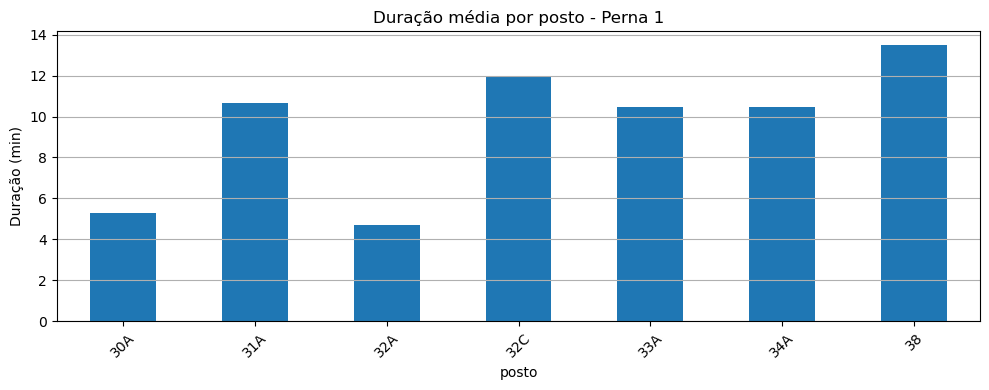

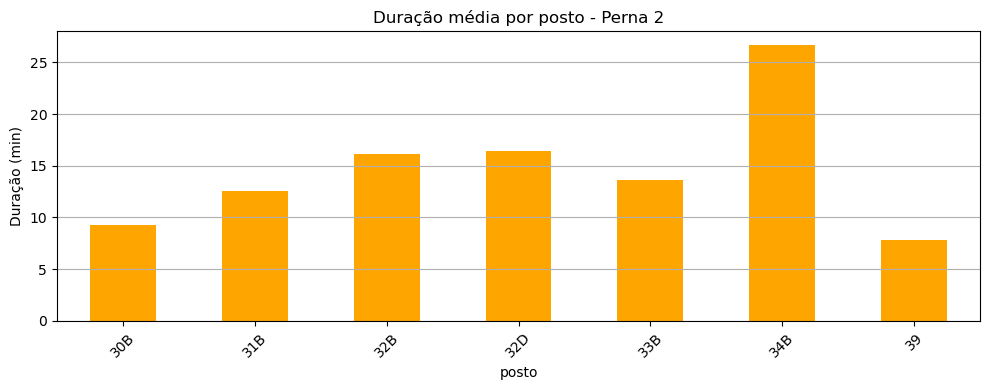

In [69]:
# GRÁFICOS

import pandas as pd
import matplotlib.pyplot as plt

# Supondo que df_log já foi criado com a simulação
df_log["duracao_min"] = df_log["duracao"] / 60

# Filtra e agrupa por perna 1
media_perna1 = df_log[df_log["perna"] == 1].groupby("posto")["duracao_min"].mean()
plt.figure(figsize=(10, 4))
media_perna1.plot(kind='bar')
plt.title("Duração média por posto - Perna 1")
plt.ylabel("Duração (min)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Filtra e agrupa por perna 2
media_perna2 = df_log[df_log["perna"] == 2].groupby("posto")["duracao_min"].mean()
plt.figure(figsize=(10, 4))
media_perna2.plot(kind='bar', color='orange')
plt.title("Duração média por posto - Perna 2")
plt.ylabel("Duração (min)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [57]:
# # CÓDIGO MELINA EXPLICADO

# TURN_DURATION = 8*3600
# TAKT_TIME =5.5*60
# #env = simpy.Environment()

# def processar_modelo(env, nome, modelo_nome, perna, postos_dict, recursos, modelos_completos):
    
#     # Processa um modelo caminhando pelos postos da perna correspondente.
#     # Espera se necessário até o posto estar livre (recurso com capacidade 1).

#     for posto, dados in postos_dict.items():
#         tempo_tot = dados["tempo_operador"]
#         with recursos[posto].request() as req: #Solicita acesso ao posto (representado por recursos[posto]), que é um simpy.Resource(capacity=1)
#             yield req # momento em que o processo espera sua vez de usar o posto. Se o posto estiver ocupado, o processo fica "dormindo" até que ele esteja livre.
#             yield env.timeout(tempo_tot) #Depois de yield req, significa que o modelo está dentro do posto e agora pode executar o env.timeout(tempo_tot) — ou seja, processar o tempo necessário.
#     # saindo do blobo with temos o release do modelo 
#     modelos_completos[f"perna{perna}"] += 1


# def simulacao_linha(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION):
    
#     # CRIA AMBIENTE SIMULAÇÃO SIMPY
#     env = simpy.Environment() 

#     # CRIANDO DICIONÁRIOS (a serem preenchidos)
#     recursos = {}  # Dicionário que terá um simpy.Resource(capacity=1) para cada posto (30A, 31B etc.). Isso garante que apenas um modelo de cada vez use o posto.
#     modelos_completos = {"perna1": 0, "perna2": 0} # dicionário que irá retornar os modelos completos 


#     def alimentador(env):
        
#         # PERCORRE BAUMUSTER NA SEQUENCIA
#         for i, baumuster in enumerate(sequencia_modelos):
           
#             yield env.timeout(i*TAKT_TIME) # faz com que cada modelo entre no seu tempo (saindo da perna 29) seguindo o takt time

#             # IDENTIFICA MODELO CORRESPONDENTE AO BAUMUSTER
#             modelo_nome = None
#             for nome, dados in MODELOS_CSV.items():
#                 if baumuster in dados["baumuster"]:
#                     modelo_nome = nome # pega o nome do modelo
#                     perna = dados["perna"] # pega sua respectiva perna
#                     break # assim que o baumuster é encontrado dentro de um modelo, não é necessário continuar procurando nos outros modelos
            
#             # Para evitar erro caso não ache o nome 
#             if modelo_nome is None:
#                 continue  # ignora se não encontrou modelo válido

#             postos_dict = resultado[modelo_nome] #pega o dicionário referente aquele modelo

#             # INICIALIZA OS RECUSROS PARA CADA POSTO (adiciona postos no dict rescurso)
#             for posto in postos_dict:
#                 if posto not in recursos:
#                     recursos[posto] = simpy.Resource(env, capacity=1)

#             # PROCESSANDO FUNCAO : PROCESSAR_MODELO
#             # A função processar_modelo(...) é um gerador com yield, ou seja, ela vai ser executada "aos poucos", sincronizada com o tempo da simulação;
#             # Cada modelo tem um nome único como "Atego_3", "Accelo_5", etc., para rastreamento;
#             # O env (ambiente da simulação), modelo_nome e o número dele (nome), perna (1 ou 2), dicionário com os tempos de cada posto (postos_dict), recursos (postos da linha),contador modelos_completos, que será incrementado quando o modelo terminar.
#             env.process(processar_modelo(
#                 env=env,
#                 nome=f"{modelo_nome}_{i}",
#                 modelo_nome=modelo_nome,
#                 perna=perna,
#                 postos_dict=postos_dict,
#                 recursos=recursos,
#                 modelos_completos=modelos_completos))


#     env.process(alimentador(env)) # função registra o alimentador como um processo da simulação; alimentador é a função que dispara os modelos a cada 5,5 minutos, simulando a saída sequencial do posto 29 (linha única)
#     env.run(until=TURN_DURATION) # determina ponto de parada após duração do turno 

#     return modelos_completos


CÓDIGO ANTERIOR

In [58]:

# def caminhao(env, id_caminhao, sequencia_modelos, fabrica, resultados):
#     tempo_entrada = env.now
   
#     # for modelo, info in MODELOS_CSV.items():
#     #     for b in info["baumuster"]:
#     #         if b in sequencia_modelos:
#     #             dados.append({"baumuster": b, "Modelo": modelo, "Perna": info["perna"]})

#     #     sequencia_atualizada = (pd.DataFrame(dados)).to_csv("sequencia_atualizada.csv", index=False)
#     #     print(f"baumuster {b} pertence ao modelo {modelo} e vai para a Perna {dados['perna']}")
    

#     modelos=[]
#     pernas=[]
#     for b in sequencia_modelos:
#         for modelo, info in MODELOS_CSV.items():
#             if b in info["baumuster"]:
#                 p = info['perna']
#                 if p == 1 :
#                 elif p == 2:

# # !!! TRAVAMOS AQUI !!!!!!
  
# # if modelo in ["Accelo", "Atego", "ATP"]: nome_linha = "Perna 1"
# # elif modelo in ["Actros", "Arocs"]: nome_linha = "Perna 2"

# #     else: return

# #     print(f"[{format_time(env.now)}] CHEGADA: Caminhão_{id_caminhao} ({modelo}) entrou na fila da {nome_linha}.")

#     operadores = fabrica['operadores'][nome_linha]
#     linha_especifica = fabrica['linhas'][nome_linha]
#     processos_modelo = PROCESSOS_FABRICA[modelo]
    
#     tempo_total_processo = sum(processos_modelo.values())
    
#     for nome_posto, tempo_proc in processos_modelo.items():
#         if nome_posto not in linha_especifica or tempo_proc <= 0: continue
        
#         posto = linha_especifica[nome_posto]
        
#         with posto.request() as req_posto, operadores.request() as req_operador:
#             yield req_posto & req_operador
            
#             yield env.timeout(tempo_proc)

#     tempo_saida = env.now
#     lead_time = tempo_saida - tempo_entrada
    
#     print(f"[{format_time(env.now)}] SAÍDA  : Caminhão_{id_caminhao} ({modelo}) finalizou. Lead Time: {format_time(lead_time)}")

#     resultados.append({
#         "ID": id_caminhao, "Modelo": modelo, "Linha": nome_linha,
#         "LeadTime_min": lead_time / 60,
#         "Tempo_Processo_min": tempo_total_processo / 60,
#         "Tempo_Espera_min": (lead_time - tempo_total_processo) / 60,
#         "Tempo_Saida_min": tempo_saida / 60,
#     })


In [59]:

# # ETAPA 2: LÓGICA DA SIMULAÇÃO

# # EXTRAINDO BAUMUSTERS DA LISTA SEQUENCIA DO DIA
# sequencia = pd.read_csv("sequencia_producao.csv", sep=';')

# # Extrai os 7 primeiros caracteres da coluna 'Baumuster'
# sequencia['Baumuster_7dig'] = sequencia['Baumuster'].astype(str).str[:7]
# sequencia_modelos = sequencia["Baumuster_7dig"].tolist()
# print(sequencia_modelos)
# #print(sequencia[['Baumuster', 'Baumuster_7dig']].head(20))

# dados =[] 

# def format_time(segundos):
#     m, s = divmod(segundos, 60); h, m = divmod(m, 60)
#     return f"{int(h):02d}:{int(m):02d}:{int(round(s,0)):02d}"

 
# def caminhao(env, id_caminhao, sequencia_modelos, fabrica, resultados):
#     tempo_entrada = env.now
   
#     for modelo, info in MODELOS_CSV.items():
#         for b in info["baumuster"]:
#             if b in sequencia_modelos:
#                 dados.append({"baumuster": b, "Modelo": modelo, "Perna": info["perna"]})

#         sequencia_atualizada = (pd.DataFrame(dados)).to_csv("sequencia_atualizada.csv", index=False)
#         print(f"baumuster {b} pertence ao modelo {modelo} e vai para a Perna {dados['perna']}")
    
#     if modelo in ["Accelo", "Atego", "ATP"]: nome_linha = "Perna 1"
#     elif modelo in ["Actros", "Arocs"]: nome_linha = "Perna 2"

#     else: return

#     print(f"[{format_time(env.now)}] CHEGADA: Caminhão_{id_caminhao} ({modelo}) entrou na fila da {nome_linha}.")

#     operadores = fabrica['operadores'][nome_linha]
#     linha_especifica = fabrica['linhas'][nome_linha]
#     processos_modelo = PROCESSOS_FABRICA[modelo]
    
#     tempo_total_processo = sum(processos_modelo.values())
    
#     for nome_posto, tempo_proc in processos_modelo.items():
#         if nome_posto not in linha_especifica or tempo_proc <= 0: continue
        
#         posto = linha_especifica[nome_posto]
        
#         with posto.request() as req_posto, operadores.request() as req_operador:
#             yield req_posto & req_operador
            
#             yield env.timeout(tempo_proc)

#     tempo_saida = env.now
#     lead_time = tempo_saida - tempo_entrada
    
#     print(f"[{format_time(env.now)}] SAÍDA  : Caminhão_{id_caminhao} ({modelo}) finalizou. Lead Time: {format_time(lead_time)}")

#     resultados.append({
#         "ID": id_caminhao, "Modelo": modelo, "Linha": nome_linha,
#         "LeadTime_min": lead_time / 60,
#         "Tempo_Processo_min": tempo_total_processo / 60,
#         "Tempo_Espera_min": (lead_time - tempo_total_processo) / 60,
#         "Tempo_Saida_min": tempo_saida / 60,
#     })

# def gerador_de_producao(env, fabrica, resultados, takt_time):
#     id_caminhao = 0
#     modelos_perna1 = [m for m in PROCESSOS_FABRICA.keys() if m in ["Accelo", "Atego", "ATP"]]
#     modelos_perna2 = [m for m in PROCESSOS_FABRICA.keys() if m in ["Actros", "Arocs"]]

#     while True:
#         id_caminhao += 1
        
#         if random.random() < 0.80 and modelos_perna1: 
#             modelo_escolhido = random.choice(modelos_perna1)
#         elif modelos_perna2:
#             modelo_escolhido = random.choice(modelos_perna2)
#         else:
#             modelo_escolhido = random.choice(list(PROCESSOS_FABRICA.keys()))

#         env.process(caminhao(env, id_caminhao, modelo_escolhido, fabrica, resultados))
#         yield env.timeout(takt_time)



In [60]:
# ETAPA 3: EXECUÇÃO E RELATÓRIOS

# if not PROCESSOS_FABRICA:
#     print("\n[ERRO FATAL] Nenhum dado foi carregado.")
# else:
#     # --- ESTRUTURA ---
#     env = simpy.Environment()
#     resultados_simulacao = []
    
#     fabrica = {
#         "operadores": {
#             "Perna 1": simpy.Resource(env, capacity=NUM_OPERADORES_PERNA1),
#             "Perna 2": simpy.Resource(env, capacity=NUM_OPERADORES_PERNA2)
#         }, "linhas": {"Perna 1": {}, "Perna 2": {}}
#     }
    
#     postos_p1 = set().union(*(p.keys() for m, p in PROCESSOS_FABRICA.items() if m in ["Accelo", "Atego", "ATP"]))
#     fabrica['linhas']['Perna 1'] = {posto: simpy.Resource(env, capacity=1) for posto in postos_p1}
#     postos_p2 = set().union(*(p.keys() for m, p in PROCESSOS_FABRICA.items() if m in ["Actros", "Arocs"]))
#     fabrica['linhas']['Perna 2'] = {posto: simpy.Resource(env, capacity=1) for posto in postos_p2}
    
#     # --- EXECUÇÃO ---
#     print("\n--- Iniciando Simulação: Cenário 'As-Is' Real ---")
#     print(f"Takt Time: {TAKT_TIME_SEGUNDOS/60:.2f} min | Perna 1: {NUM_OPERADORES_PERNA1} op. | Perna 2: {NUM_OPERADORES_PERNA2} op.")
    
#     env.process(gerador_de_producao(env, fabrica, resultados_simulacao, TAKT_TIME_SEGUNDOS))
#     env.run(until=HORAS_SIMULACAO * 3600)
    
#     print("\n" + "="*60)
#     print("      RELATÓRIO GERENCIAL DA SIMULAÇÃO (AS-IS)")
#     print("="*60)

#     # --- ANÁLISE DOS RESULTADOS ---
#     df_resultados = pd.DataFrame(resultados_simulacao)
    
#     if df_resultados.empty:
#         print("\nNenhum caminhão completou a produção.")
#     else:
#         # 1. Análise da Meta de Produção
#         df_meta_batida = df_resultados[df_resultados['Tempo_Saida_min'] <= HORAS_META * 60]
#         qtd_na_meta = len(df_meta_batida)
        
#         print("\n--- 1. ANÁLISE DA META DE PRODUÇÃO (c/ 'Fator Cagaço') ---")
#         if qtd_na_meta >= META_PRODUCAO:
#             print(f" SUCESSO! A meta foi batida, com {qtd_na_meta} caminhões produzidos nas primeiras {HORAS_META} horas.")
#         else:
#             print(f" FALHA! Apenas {qtd_na_meta} de {META_PRODUCAO} caminhões foram produzidos nas primeiras {HORAS_META} horas.")

#         # 2. Análise de Desempenho
#         print("\n--- 2. DESEMPENHO POR PERNA ---")
#         desempenho = df_resultados.groupby('Linha').agg(
#             Qtd_Produzida=('ID', 'count'),
#             Lead_Time_Medio_min=('LeadTime_min', 'mean'),
#             Tempo_Medio_Espera_min=('Tempo_Espera_min', 'mean')
#         ).round(2)
#         print(desempenho)

#         # 3. Novo Relatório Visual
#         print("\n--- 3. Gerando Relatório Visual Gerencial ---")
#         fig, axes = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1]})
#         fig.suptitle('Relatório Gerencial da Simulação (Cenário As-Is Real)', fontsize=20)

#         # Gráfico 1: Produção por Perna
#         prod_counts = df_resultados['Linha'].value_counts().reindex(['Perna 1', 'Perna 2']).fillna(0)
#         sns.barplot(x=prod_counts.index, y=prod_counts.values, ax=axes[0], palette='viridis', hue=prod_counts.index, legend=False)
#         axes[0].set_title('Produção Total por Perna', fontsize=16)
#         axes[0].set_ylabel('Qtd. de Caminhões Produzida')
#         axes[0].set_ylim(0, prod_counts.max() * 1.15)
#         for i, v in enumerate(prod_counts.values):
#             axes[0].text(i, v, str(int(v)), ha='center', va='bottom', fontsize=14)
        
#         # Gráfico 2: Lead Time por Perna
#         sns.boxplot(x='Linha', y='LeadTime_min', data=df_resultados, ax=axes[1], palette='coolwarm', hue='Linha', order=['Perna 1', 'Perna 2'], legend=False)
#         axes[1].set_title('Lead Time por Perna', fontsize=16)
#         axes[1].set_ylabel('Tempo Total de Produção (minutos)')
        
#         plt.tight_layout(rect=[0, 0, 1, 0.96])
#         plt.savefig('relatorio_gerencial_real.png')
#         print(" SUCESSO: Gráfico 'relatorio_gerencial_real.png' salvo.")